# Deep Dive: Intern vs Student Commute Patterns

## Refined Hypotheses

### Finance Interns
- **Arrival time**: 8-11am (bankers can come in late, not 7am like regular workers)
- **Direction**: Trips should END at banks (commuting TO work)
- **Evening asymmetry**: May NOT bike home (work late, take car service)
- **Days**: Strictly weekdays
- **Duration**: June 8 - August 15

### College Students  
- **Arrival time**: Variable (9am, 10am, 11am, 1pm classes)
- **Direction**: Both TO and FROM campus throughout day
- **Pattern**: Less peaked, more spread throughout day
- **Days**: Primarily weekdays, some weekend activity
- **Duration**: September - May

## Key Tests
1. **Arrival time distribution**: Interns peaked 8-10am, students flatter
2. **Departure asymmetry**: Interns don't leave on bikes (work late)
3. **Bank-specific patterns**: Goldman (brutal hours) vs others
4. **Trip direction**: TO vs FROM analysis

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

INTERN_COLOR = '#e74c3c'
STUDENT_COLOR = '#3498db'
CONTROL_COLOR = '#95a5a6'

con = duckdb.connect()
print('Connected')

Connected


## 1. Define Precise Location Groups

We need to be very specific about which stations are near which banks/universities.

In [2]:
# Get all stations
all_stations = con.execute("""
    SELECT start_station_name as station, start_lat as lat, start_lon as lon, COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE birth_year_valid = TRUE AND gender_valid = TRUE AND start_lat IS NOT NULL
    GROUP BY 1, 2, 3 HAVING COUNT(*) >= 5000
""").fetchdf()

# Individual bank HQ locations (more precise)
BANKS = {
    'Goldman Sachs': {'coords': (-74.0135, 40.7145), 'culture': 'brutal_hours'},
    'JPMorgan': {'coords': (-73.9762, 40.7567), 'culture': 'moderate'},
    'Citigroup': {'coords': (-74.0103, 40.7201), 'culture': 'moderate'},
    'Bank of America': {'coords': (-73.9840, 40.7556), 'culture': 'moderate'},
    'Morgan Stanley': {'coords': (-73.9850, 40.7600), 'culture': 'moderate'},
}

# Universities with different characteristics
UNIVERSITIES = {
    'NYU': {'coords': (-73.9973, 40.7308), 'type': 'large_urban'},
    'Columbia': {'coords': (-73.9626, 40.8075), 'type': 'campus'},
    'Baruch': {'coords': (-73.9833, 40.7403), 'type': 'commuter'},
    'Pace': {'coords': (-74.0040, 40.7112), 'type': 'commuter'},
    'New School': {'coords': (-73.9937, 40.7353), 'type': 'urban'},
}

def find_nearby(lon, lat, df, radius=0.003):
    mask = ((df['lon'] - lon).abs() < radius) & ((df['lat'] - lat).abs() < radius)
    return df[mask]['station'].tolist()

# Build station lists for each specific location
bank_station_map = {}
for name, info in BANKS.items():
    lon, lat = info['coords']
    stations = find_nearby(lon, lat, all_stations)
    bank_station_map[name] = stations
    print(f"{name}: {len(stations)} stations - {stations[:2]}...")

print()
uni_station_map = {}
for name, info in UNIVERSITIES.items():
    lon, lat = info['coords']
    stations = find_nearby(lon, lat, all_stations)
    uni_station_map[name] = stations
    print(f"{name}: {len(stations)} stations - {stations[:2]}...")

# Flatten for queries
all_bank_stations = [s for stations in bank_station_map.values() for s in stations]
all_uni_stations = [s for stations in uni_station_map.values() for s in stations]
print(f"\nTotal bank stations: {len(all_bank_stations)}")
print(f"Total university stations: {len(all_uni_stations)}")

Goldman Sachs: 2 stations - ['Murray St & West St', 'Murray St & Greenwich St']...
JPMorgan: 2 stations - ['E 47 St & Park Ave', 'E 48 St & 5 Ave']...
Citigroup: 5 stations - ['North Moore St & Greenwich St', 'Greenwich St & Hubert St']...
Bank of America: 3 stations - ['W 43 St & 6 Ave', '6 Ave & W 45 St']...
Morgan Stanley: 2 stations - ['W 49 St & 8 Ave', 'Broadway & W 48 St']...

NYU: 8 stations - ['Sullivan St & Washington Sq', 'Thompson St & Bleecker St']...
Columbia: 4 stations - ['Amsterdam Ave & W 119 St', 'W 113 St & Broadway']...
Baruch: 4 stations - ['E 24 St & Park Ave S', 'Lexington Ave & E 24 St']...
Pace: 5 stations - ['Gold St & Frankfort St', 'Cliff St & Fulton St']...
New School: 6 stations - ['W 13 St & 5 Ave', 'E 10 St & 5 Ave']...

Total bank stations: 14
Total university stations: 27


## 2. Trip Direction Analysis: TO vs FROM

**Key insight**: Interns commute TO banks in the morning. If they work late, they may not bike FROM banks in evening.

We should see:
- Morning: Many trips ENDING at banks (arrivals)
- Evening: Fewer trips STARTING at banks (departures) - they're still working!

In [3]:
# Get hourly trips TO and FROM banks/universities by direction
hourly_direction = con.execute("""
    SELECT 
        EXTRACT(HOUR FROM started_at) as hour,
        CASE 
            WHEN EXTRACT(MONTH FROM started_at) IN (6, 7, 8) THEN 'summer'
            ELSE 'academic'
        END as season,
        -- TO banks (trip ends at bank)
        SUM(CASE WHEN end_station_name IN (SELECT UNNEST(?::VARCHAR[])) THEN 1 ELSE 0 END) as to_bank,
        -- FROM banks (trip starts at bank)
        SUM(CASE WHEN start_station_name IN (SELECT UNNEST(?::VARCHAR[])) THEN 1 ELSE 0 END) as from_bank,
        -- TO universities
        SUM(CASE WHEN end_station_name IN (SELECT UNNEST(?::VARCHAR[])) THEN 1 ELSE 0 END) as to_uni,
        -- FROM universities
        SUM(CASE WHEN start_station_name IN (SELECT UNNEST(?::VARCHAR[])) THEN 1 ELSE 0 END) as from_uni
    FROM '../data/processed/*.parquet'
    WHERE birth_year_valid = TRUE AND gender_valid = TRUE
      AND age_at_trip BETWEEN 20 AND 25
      AND gender = 1  -- Male
      AND DAYOFWEEK(started_at) NOT IN (0, 6)  -- Weekday
      AND EXTRACT(YEAR FROM started_at) BETWEEN 2014 AND 2019
    GROUP BY 1, 2
    ORDER BY 2, 1
""", [all_bank_stations, all_bank_stations, all_uni_stations, all_uni_stations]).fetchdf()

print("Hourly trip counts by direction (Young males 20-25, weekdays):")
display(hourly_direction.head(10))

Hourly trip counts by direction (Young males 20-25, weekdays):


,hour,season,to_bank,from_bank,to_uni,from_uni
0,0,academic,573.0,682.0,2206.0,4013.0
1,1,academic,289.0,400.0,1246.0,2055.0
2,2,academic,192.0,234.0,716.0,1157.0
3,3,academic,89.0,102.0,365.0,642.0
4,4,academic,431.0,103.0,372.0,484.0
5,5,academic,3823.0,260.0,967.0,1405.0
6,6,academic,12661.0,1699.0,4947.0,3690.0
7,7,academic,15124.0,3121.0,12374.0,5901.0
8,8,academic,20625.0,5614.0,23937.0,12850.0
9,9,academic,10189.0,4765.0,23459.0,12484.0


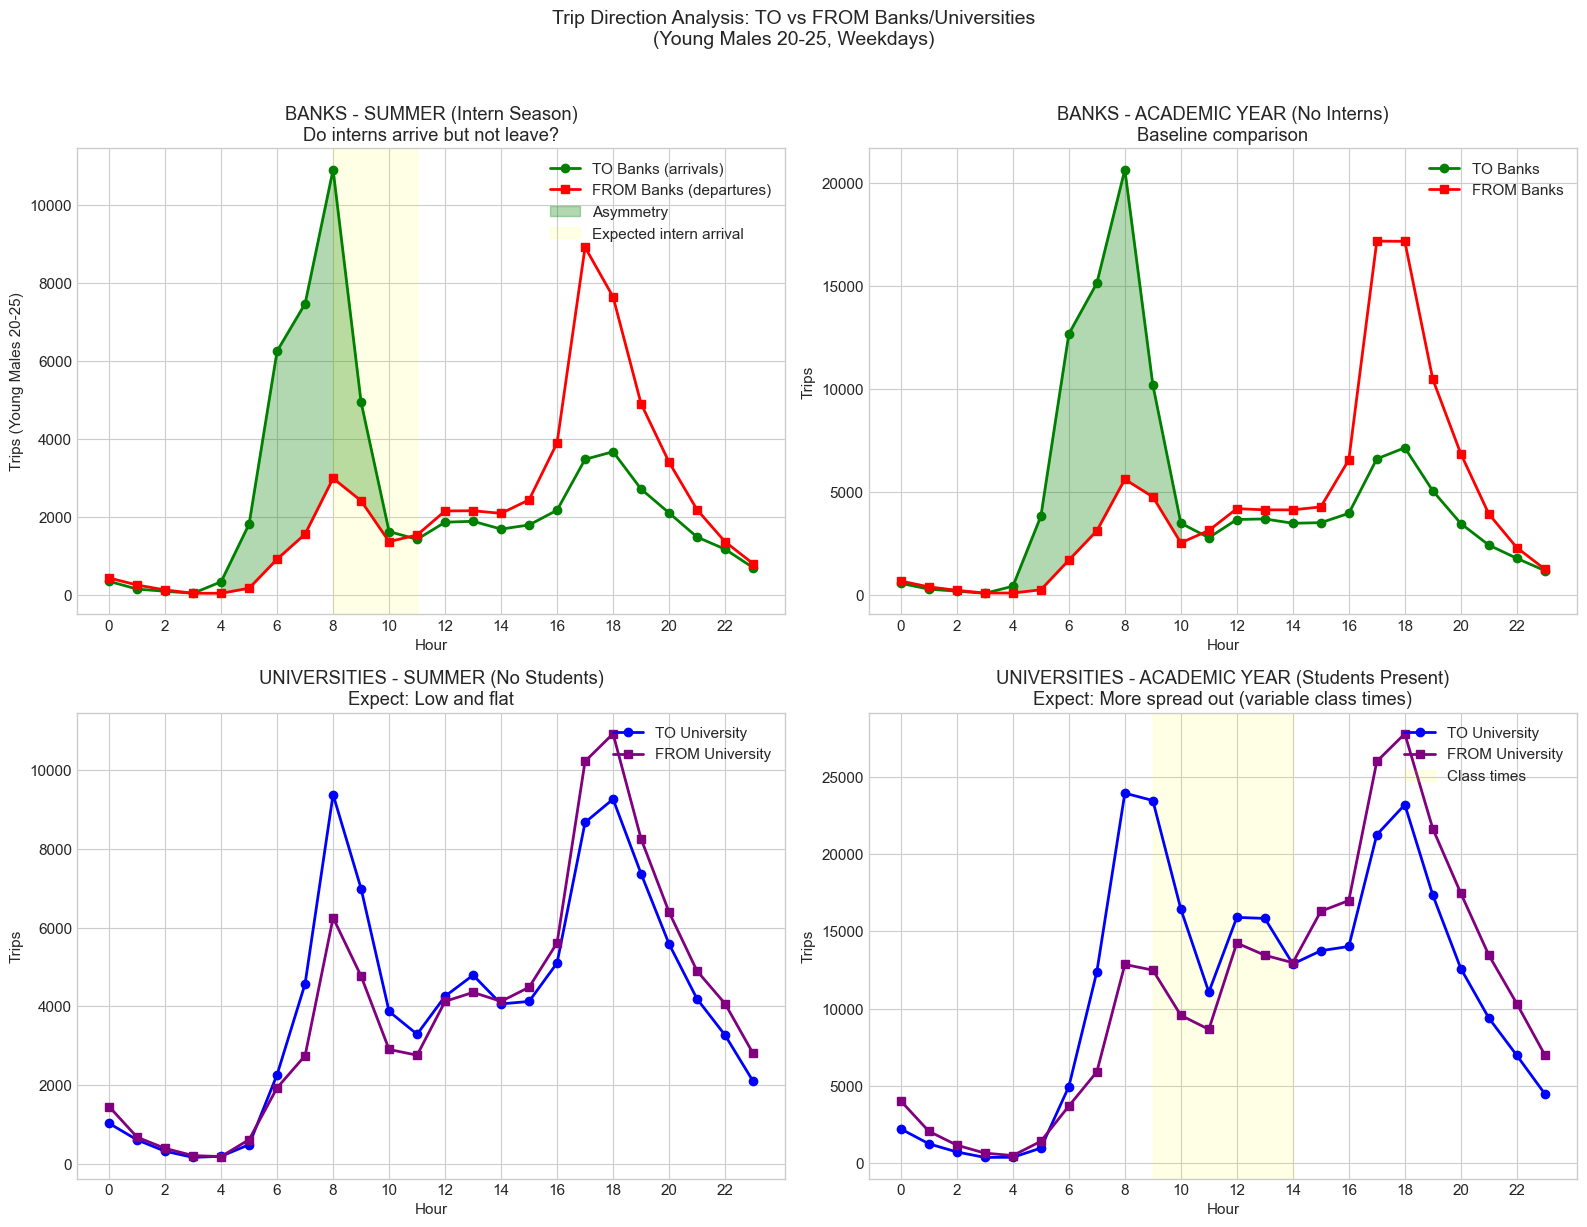

In [4]:
# Visualize TO vs FROM asymmetry
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

summer = hourly_direction[hourly_direction['season'] == 'summer'].sort_values('hour')
academic = hourly_direction[hourly_direction['season'] == 'academic'].sort_values('hour')

# Top Left: Banks - Summer (intern season)
ax = axes[0, 0]
ax.plot(summer['hour'], summer['to_bank'], marker='o', label='TO Banks (arrivals)', color='green', linewidth=2)
ax.plot(summer['hour'], summer['from_bank'], marker='s', label='FROM Banks (departures)', color='red', linewidth=2)
ax.fill_between(summer['hour'], summer['to_bank'], summer['from_bank'], 
                where=summer['to_bank'] > summer['from_bank'], alpha=0.3, color='green', label='Asymmetry')
ax.axvspan(8, 11, alpha=0.1, color='yellow', label='Expected intern arrival')
ax.set_xlabel('Hour')
ax.set_ylabel('Trips (Young Males 20-25)')
ax.set_title('BANKS - SUMMER (Intern Season)\nDo interns arrive but not leave?')
ax.legend(loc='upper right')
ax.set_xticks(range(0, 24, 2))

# Top Right: Banks - Academic year (no interns)
ax = axes[0, 1]
ax.plot(academic['hour'], academic['to_bank'], marker='o', label='TO Banks', color='green', linewidth=2)
ax.plot(academic['hour'], academic['from_bank'], marker='s', label='FROM Banks', color='red', linewidth=2)
ax.fill_between(academic['hour'], academic['to_bank'], academic['from_bank'],
                where=academic['to_bank'] > academic['from_bank'], alpha=0.3, color='green')
ax.set_xlabel('Hour')
ax.set_ylabel('Trips')
ax.set_title('BANKS - ACADEMIC YEAR (No Interns)\nBaseline comparison')
ax.legend(loc='upper right')
ax.set_xticks(range(0, 24, 2))

# Bottom Left: Universities - Summer (no students)
ax = axes[1, 0]
ax.plot(summer['hour'], summer['to_uni'], marker='o', label='TO University', color='blue', linewidth=2)
ax.plot(summer['hour'], summer['from_uni'], marker='s', label='FROM University', color='purple', linewidth=2)
ax.set_xlabel('Hour')
ax.set_ylabel('Trips')
ax.set_title('UNIVERSITIES - SUMMER (No Students)\nExpect: Low and flat')
ax.legend(loc='upper right')
ax.set_xticks(range(0, 24, 2))

# Bottom Right: Universities - Academic year (students present)
ax = axes[1, 1]
ax.plot(academic['hour'], academic['to_uni'], marker='o', label='TO University', color='blue', linewidth=2)
ax.plot(academic['hour'], academic['from_uni'], marker='s', label='FROM University', color='purple', linewidth=2)
ax.axvspan(9, 14, alpha=0.1, color='yellow', label='Class times')
ax.set_xlabel('Hour')
ax.set_ylabel('Trips')
ax.set_title('UNIVERSITIES - ACADEMIC YEAR (Students Present)\nExpect: More spread out (variable class times)')
ax.legend(loc='upper right')
ax.set_xticks(range(0, 24, 2))

plt.suptitle('Trip Direction Analysis: TO vs FROM Banks/Universities\n(Young Males 20-25, Weekdays)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [5]:
# Calculate the arrival/departure asymmetry ratio
def calc_asymmetry(df, to_col, from_col, morning_hours, evening_hours):
    """Calculate ratio of morning arrivals to evening departures"""
    morning_arrivals = df[df['hour'].isin(morning_hours)][to_col].sum()
    evening_departures = df[df['hour'].isin(evening_hours)][from_col].sum()
    return morning_arrivals / evening_departures if evening_departures > 0 else float('inf')

morning = [8, 9, 10]
evening = [17, 18, 19]

print("Arrival/Departure Asymmetry (Morning TO / Evening FROM)")
print("=" * 60)
print("\nRatio > 1 means: More people arrive in AM than leave in PM")
print("(Higher ratio = more people staying late / not biking home)")
print()

bank_summer_asym = calc_asymmetry(summer, 'to_bank', 'from_bank', morning, evening)
bank_academic_asym = calc_asymmetry(academic, 'to_bank', 'from_bank', morning, evening)
uni_summer_asym = calc_asymmetry(summer, 'to_uni', 'from_uni', morning, evening)
uni_academic_asym = calc_asymmetry(academic, 'to_uni', 'from_uni', morning, evening)

print(f"{'Location':<20} {'Summer':<15} {'Academic':<15} {'Interpretation'}")
print("-" * 70)
print(f"{'Banks':<20} {bank_summer_asym:<15.2f} {bank_academic_asym:<15.2f} {'Interns work late!' if bank_summer_asym > bank_academic_asym else 'Unexpected'}")
print(f"{'Universities':<20} {uni_summer_asym:<15.2f} {uni_academic_asym:<15.2f} {'Students more balanced' if uni_academic_asym < bank_academic_asym else ''}")

Arrival/Departure Asymmetry (Morning TO / Evening FROM)

Ratio > 1 means: More people arrive in AM than leave in PM
(Higher ratio = more people staying late / not biking home)

Location             Summer          Academic        Interpretation
----------------------------------------------------------------------
Banks                0.81            0.77            Interns work late!
Universities         0.69            0.85            


## 3. Arrival Time Distribution: When Do They Show Up?

**Hypothesis**:
- Finance interns: Peak 8-10am (can come in a bit late, but not 7am early birds)
- Students: Flatter distribution (9am, 10am, 11am, afternoon classes)
- Full-time workers (35-45): Sharp 8am peak

In [6]:
# Compare arrival time distributions by age group
arrival_by_age = con.execute("""
    SELECT 
        EXTRACT(HOUR FROM started_at) as hour,
        CASE 
            WHEN EXTRACT(MONTH FROM started_at) IN (6, 7, 8) THEN 'summer'
            ELSE 'academic'
        END as season,
        CASE 
            WHEN age_at_trip BETWEEN 20 AND 25 THEN 'young_20_25'
            WHEN age_at_trip BETWEEN 35 AND 45 THEN 'experienced_35_45'
        END as age_group,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE birth_year_valid = TRUE AND gender_valid = TRUE
      AND end_station_name IN (SELECT UNNEST(?::VARCHAR[]))  -- Trips TO banks
      AND gender = 1
      AND DAYOFWEEK(started_at) NOT IN (0, 6)
      AND EXTRACT(YEAR FROM started_at) BETWEEN 2014 AND 2019
      AND age_at_trip BETWEEN 20 AND 45
    GROUP BY 1, 2, 3
""", [all_bank_stations]).fetchdf()

# Normalize each group to show distribution
arrival_by_age['trips_norm'] = arrival_by_age.groupby(['season', 'age_group'])['trips'].transform(lambda x: x / x.sum() * 100)

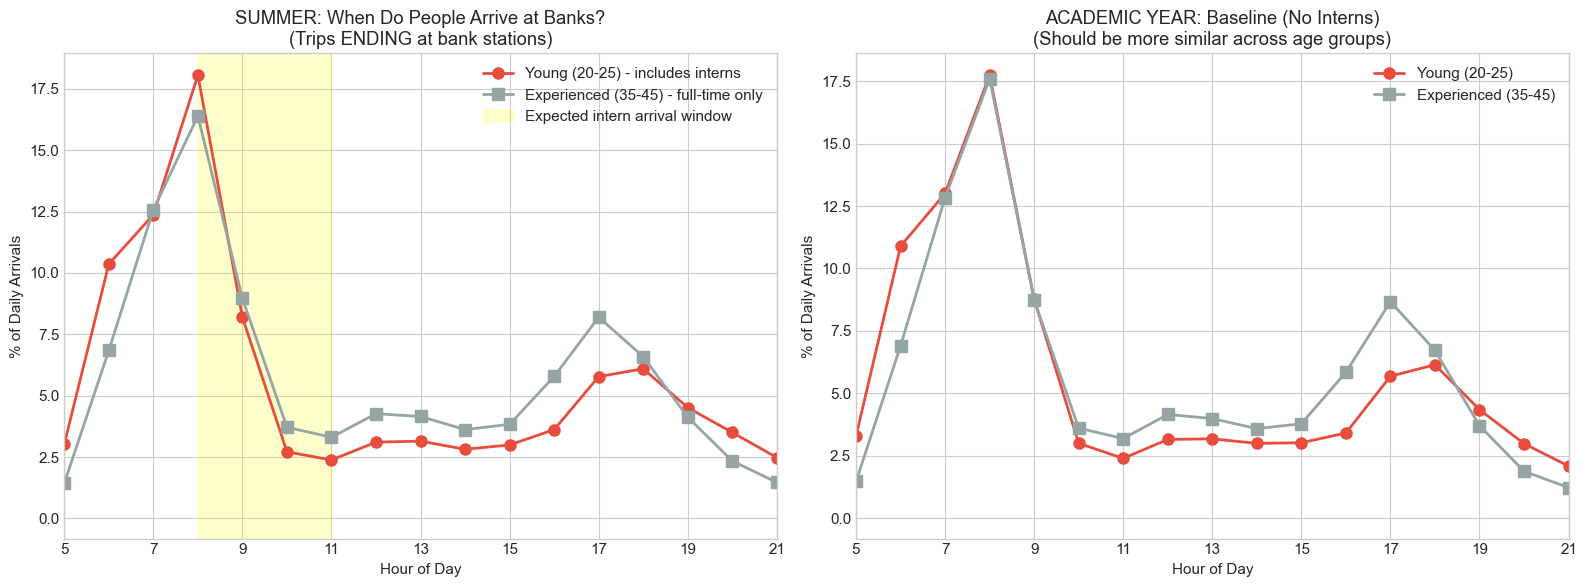


Summer peak arrival hour:
  Young (20-25): 8:00
  Experienced (35-45): 8:00


In [7]:
# Plot arrival time distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Summer (intern season)
ax = axes[0]
summer_young = arrival_by_age[(arrival_by_age['season'] == 'summer') & (arrival_by_age['age_group'] == 'young_20_25')].sort_values('hour')
summer_exp = arrival_by_age[(arrival_by_age['season'] == 'summer') & (arrival_by_age['age_group'] == 'experienced_35_45')].sort_values('hour')

ax.plot(summer_young['hour'], summer_young['trips_norm'], marker='o', label='Young (20-25) - includes interns', 
        color=INTERN_COLOR, linewidth=2, markersize=8)
ax.plot(summer_exp['hour'], summer_exp['trips_norm'], marker='s', label='Experienced (35-45) - full-time only',
        color=CONTROL_COLOR, linewidth=2, markersize=8)

ax.axvspan(8, 11, alpha=0.2, color='yellow', label='Expected intern arrival window')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('% of Daily Arrivals')
ax.set_title('SUMMER: When Do People Arrive at Banks?\n(Trips ENDING at bank stations)')
ax.legend()
ax.set_xticks(range(5, 22, 2))
ax.set_xlim(5, 21)

# Right: Academic year (no interns)
ax = axes[1]
acad_young = arrival_by_age[(arrival_by_age['season'] == 'academic') & (arrival_by_age['age_group'] == 'young_20_25')].sort_values('hour')
acad_exp = arrival_by_age[(arrival_by_age['season'] == 'academic') & (arrival_by_age['age_group'] == 'experienced_35_45')].sort_values('hour')

ax.plot(acad_young['hour'], acad_young['trips_norm'], marker='o', label='Young (20-25)',
        color=INTERN_COLOR, linewidth=2, markersize=8)
ax.plot(acad_exp['hour'], acad_exp['trips_norm'], marker='s', label='Experienced (35-45)',
        color=CONTROL_COLOR, linewidth=2, markersize=8)

ax.set_xlabel('Hour of Day')
ax.set_ylabel('% of Daily Arrivals')
ax.set_title('ACADEMIC YEAR: Baseline (No Interns)\n(Should be more similar across age groups)')
ax.legend()
ax.set_xticks(range(5, 22, 2))
ax.set_xlim(5, 21)

plt.tight_layout()
plt.show()

# Calculate peak hour shift
summer_young_peak = summer_young.loc[summer_young['trips_norm'].idxmax(), 'hour']
summer_exp_peak = summer_exp.loc[summer_exp['trips_norm'].idxmax(), 'hour']
print(f"\nSummer peak arrival hour:")
print(f"  Young (20-25): {int(summer_young_peak)}:00")
print(f"  Experienced (35-45): {int(summer_exp_peak)}:00")

## 4. Bank-Specific Patterns: Goldman vs Others

Goldman Sachs is notorious for brutal hours. Do we see this in the data?

**Hypothesis**: Goldman interns have HIGHER arrival/departure asymmetry (more staying late)

In [8]:
# Analyze each bank separately
bank_specific = {}

for bank_name, stations in bank_station_map.items():
    if len(stations) == 0:
        continue
        
    result = con.execute("""
        SELECT 
            EXTRACT(HOUR FROM started_at) as hour,
            -- TO bank (arrivals)
            SUM(CASE WHEN end_station_name IN (SELECT UNNEST(?::VARCHAR[])) THEN 1 ELSE 0 END) as arrivals,
            -- FROM bank (departures)  
            SUM(CASE WHEN start_station_name IN (SELECT UNNEST(?::VARCHAR[])) THEN 1 ELSE 0 END) as departures
        FROM '../data/processed/*.parquet'
        WHERE birth_year_valid = TRUE AND gender_valid = TRUE
          AND age_at_trip BETWEEN 20 AND 25
          AND gender = 1
          AND DAYOFWEEK(started_at) NOT IN (0, 6)
          AND EXTRACT(MONTH FROM started_at) IN (6, 7, 8)  -- Summer only
          AND EXTRACT(YEAR FROM started_at) BETWEEN 2014 AND 2019
        GROUP BY 1
        ORDER BY 1
    """, [stations, stations]).fetchdf()
    
    bank_specific[bank_name] = result

print("Bank-specific data loaded for:", list(bank_specific.keys()))

Bank-specific data loaded for: ['Goldman Sachs', 'JPMorgan', 'Citigroup', 'Bank of America', 'Morgan Stanley']


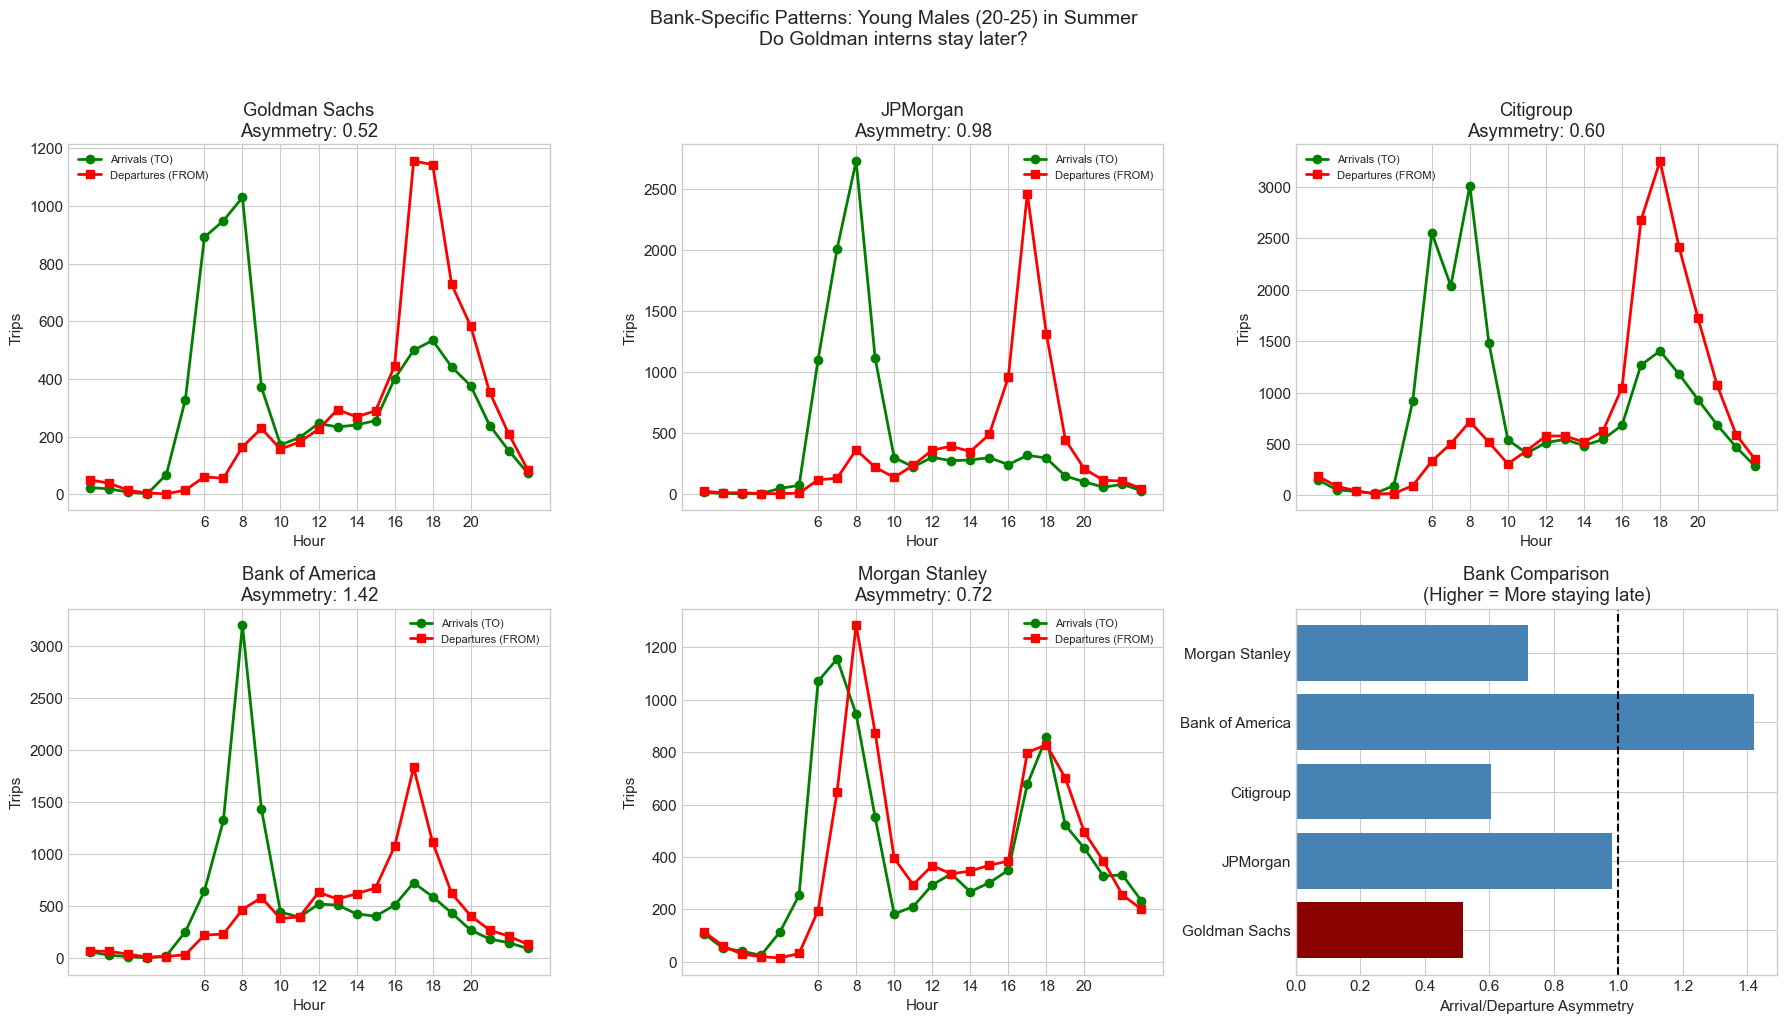


Asymmetry Ranking (higher = more brutal hours):
  Bank of America: 1.42
  JPMorgan: 0.98
  Morgan Stanley: 0.72
  Citigroup: 0.60
  Goldman Sachs: 0.52


In [9]:
# Compare arrival/departure patterns by bank
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

bank_asymmetries = {}

for idx, (bank_name, df) in enumerate(bank_specific.items()):
    if idx >= 5:  # Only plot first 5
        break
    ax = axes[idx]
    
    df = df.sort_values('hour')
    ax.plot(df['hour'], df['arrivals'], marker='o', label='Arrivals (TO)', color='green', linewidth=2)
    ax.plot(df['hour'], df['departures'], marker='s', label='Departures (FROM)', color='red', linewidth=2)
    
    # Calculate asymmetry
    morning_arr = df[df['hour'].isin([8, 9, 10])]['arrivals'].sum()
    evening_dep = df[df['hour'].isin([17, 18, 19])]['departures'].sum()
    asymmetry = morning_arr / evening_dep if evening_dep > 0 else 0
    bank_asymmetries[bank_name] = asymmetry
    
    ax.set_title(f'{bank_name}\nAsymmetry: {asymmetry:.2f}')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Trips')
    ax.legend(fontsize=8)
    ax.set_xticks(range(6, 22, 2))

# Summary in last subplot
ax = axes[5]
banks = list(bank_asymmetries.keys())
asyms = list(bank_asymmetries.values())
colors = ['darkred' if 'Goldman' in b else 'steelblue' for b in banks]
ax.barh(banks, asyms, color=colors)
ax.axvline(x=1.0, color='black', linestyle='--', label='Balanced (1.0)')
ax.set_xlabel('Arrival/Departure Asymmetry')
ax.set_title('Bank Comparison\n(Higher = More staying late)')

plt.suptitle('Bank-Specific Patterns: Young Males (20-25) in Summer\nDo Goldman interns stay later?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nAsymmetry Ranking (higher = more brutal hours):")
for bank, asym in sorted(bank_asymmetries.items(), key=lambda x: -x[1]):
    print(f"  {bank}: {asym:.2f}")

## 5. Student Arrival Patterns: More Spread Out?

**Hypothesis**: Students have classes at various times (9am, 10am, 11am, 1pm, etc.)
So their arrival distribution should be FLATTER than workers.

In [10]:
# Compare student arrival distribution (academic year) to bank workers
student_arrivals = con.execute("""
    SELECT 
        EXTRACT(HOUR FROM started_at) as hour,
        CASE 
            WHEN age_at_trip BETWEEN 18 AND 22 THEN 'likely_undergrad'
            WHEN age_at_trip BETWEEN 23 AND 26 THEN 'likely_grad'
            WHEN age_at_trip BETWEEN 35 AND 45 THEN 'staff_faculty'
        END as group_type,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE birth_year_valid = TRUE AND gender_valid = TRUE
      AND end_station_name IN (SELECT UNNEST(?::VARCHAR[]))  -- Trips TO universities
      AND DAYOFWEEK(started_at) NOT IN (0, 6)  -- Weekday
      AND EXTRACT(MONTH FROM started_at) NOT IN (6, 7, 8)  -- Academic year
      AND EXTRACT(YEAR FROM started_at) BETWEEN 2014 AND 2019
    GROUP BY 1, 2
""", [all_uni_stations]).fetchdf()

# Normalize
student_arrivals['trips_norm'] = student_arrivals.groupby('group_type')['trips'].transform(lambda x: x / x.sum() * 100)

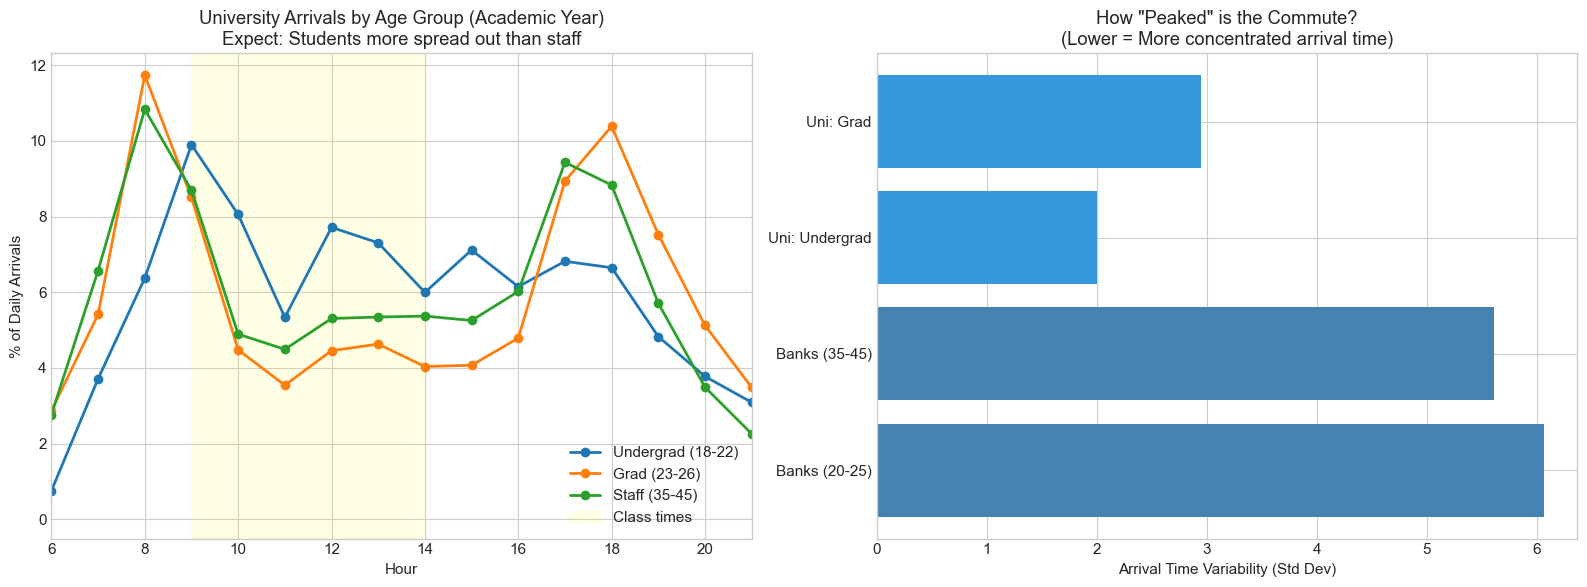


Arrival Time Spread Analysis:
Lower spread = more concentrated arrival time (typical of workers)
Higher spread = more variable arrival time (typical of students with different class schedules)


In [11]:
# Compare distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Student arrival patterns
ax = axes[0]
for group in ['likely_undergrad', 'likely_grad', 'staff_faculty']:
    data = student_arrivals[student_arrivals['group_type'] == group].sort_values('hour')
    if len(data) > 0:
        label = {'likely_undergrad': 'Undergrad (18-22)', 'likely_grad': 'Grad (23-26)', 'staff_faculty': 'Staff (35-45)'}[group]
        ax.plot(data['hour'], data['trips_norm'], marker='o', label=label, linewidth=2, markersize=6)

ax.axvspan(9, 14, alpha=0.1, color='yellow', label='Class times')
ax.set_xlabel('Hour')
ax.set_ylabel('% of Daily Arrivals')
ax.set_title('University Arrivals by Age Group (Academic Year)\nExpect: Students more spread out than staff')
ax.legend()
ax.set_xticks(range(6, 22, 2))
ax.set_xlim(6, 21)

# Right: Compare spread (coefficient of variation in morning hours)
ax = axes[1]

# Get bank arrivals for comparison
bank_arrivals_acad = arrival_by_age[
    (arrival_by_age['season'] == 'academic') & 
    (arrival_by_age['hour'].isin(range(7, 14)))
]

# Calculate "spread" - standard deviation of morning arrivals
def calc_spread(df, norm_col='trips_norm'):
    return df[norm_col].std() / df[norm_col].mean() * 100

spreads = {
    'Banks (20-25)': bank_arrivals_acad[bank_arrivals_acad['age_group'] == 'young_20_25']['trips_norm'].std(),
    'Banks (35-45)': bank_arrivals_acad[bank_arrivals_acad['age_group'] == 'experienced_35_45']['trips_norm'].std(),
}

for group in ['likely_undergrad', 'likely_grad']:
    data = student_arrivals[(student_arrivals['group_type'] == group) & (student_arrivals['hour'].isin(range(7, 14)))]
    if len(data) > 0:
        label = {'likely_undergrad': 'Uni: Undergrad', 'likely_grad': 'Uni: Grad'}[group]
        spreads[label] = data['trips_norm'].std()

ax.barh(list(spreads.keys()), list(spreads.values()), color=['steelblue', 'steelblue', STUDENT_COLOR, STUDENT_COLOR])
ax.set_xlabel('Arrival Time Variability (Std Dev)')
ax.set_title('How "Peaked" is the Commute?\n(Lower = More concentrated arrival time)')

plt.tight_layout()
plt.show()

print("\nArrival Time Spread Analysis:")
print("Lower spread = more concentrated arrival time (typical of workers)")
print("Higher spread = more variable arrival time (typical of students with different class schedules)")

## 6. The Intern Summer Surge: Trips TO Banks 8-11am

Let's focus specifically on the hypothesized intern arrival window and see if there's a clear summer surge.

In [12]:
# Monthly trips TO banks during 8-11am for young males
intern_window = con.execute("""
    SELECT 
        EXTRACT(YEAR FROM started_at) as year,
        EXTRACT(MONTH FROM started_at) as month,
        CASE 
            WHEN age_at_trip BETWEEN 20 AND 25 THEN 'young'
            WHEN age_at_trip BETWEEN 35 AND 45 THEN 'experienced'
        END as age_group,
        COUNT(*) as trips
    FROM '../data/processed/*.parquet'
    WHERE birth_year_valid = TRUE AND gender_valid = TRUE
      AND end_station_name IN (SELECT UNNEST(?::VARCHAR[]))  -- TO banks
      AND gender = 1
      AND DAYOFWEEK(started_at) NOT IN (0, 6)
      AND EXTRACT(HOUR FROM started_at) BETWEEN 8 AND 11  -- Intern arrival window
      AND EXTRACT(YEAR FROM started_at) BETWEEN 2014 AND 2019
      AND age_at_trip BETWEEN 20 AND 45
    GROUP BY 1, 2, 3
""", [all_bank_stations]).fetchdf()

# Pivot and calculate ratio
intern_pivot = intern_window.groupby(['year', 'month', 'age_group'])['trips'].sum().unstack('age_group').fillna(0)
intern_pivot['ratio'] = intern_pivot['young'] / intern_pivot['experienced']
intern_pivot = intern_pivot.reset_index()

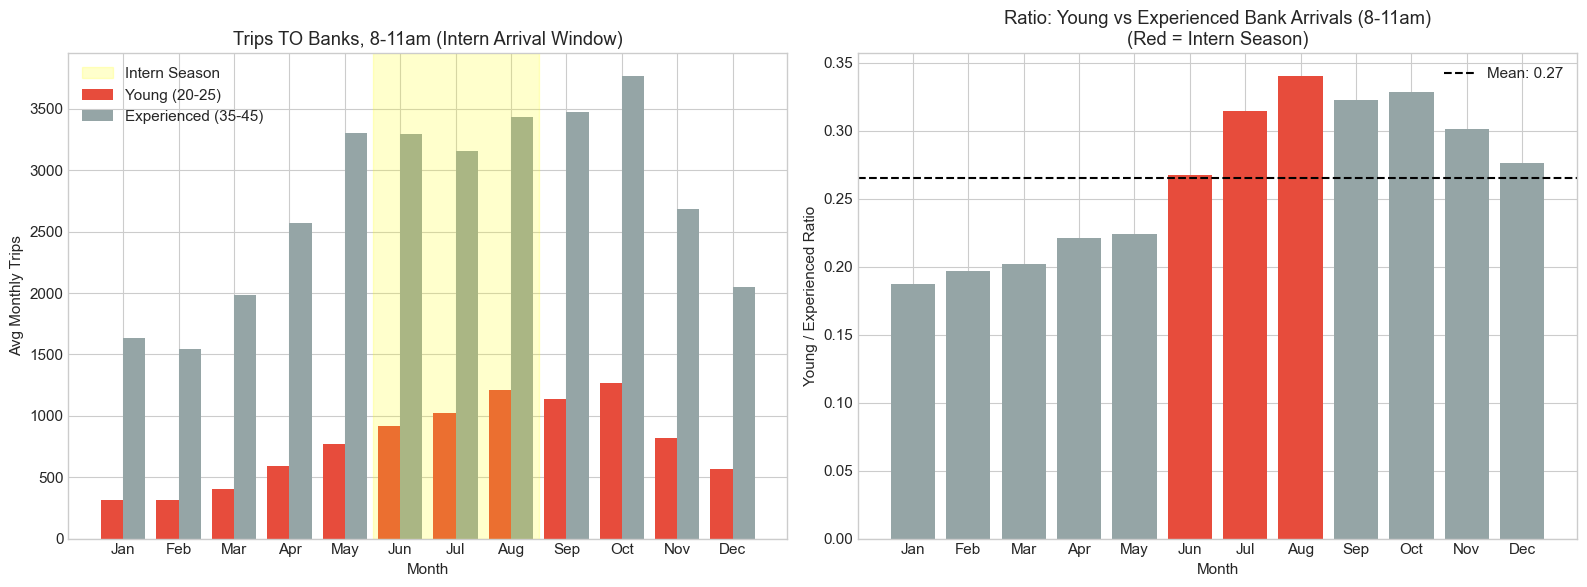


Intern Window (8-11am TO Banks) Analysis:
  Summer young/experienced ratio: 0.307
  Non-summer ratio: 0.251
  Summer boost: +22.4%


In [13]:
# Average by month across years
monthly_avg = intern_pivot.groupby('month').agg({
    'young': 'mean',
    'experienced': 'mean',
    'ratio': 'mean'
}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = range(12)

# Left: Absolute trips
ax = axes[0]
ax.bar([i-0.2 for i in x], monthly_avg['young'], 0.4, label='Young (20-25)', color=INTERN_COLOR)
ax.bar([i+0.2 for i in x], monthly_avg['experienced'], 0.4, label='Experienced (35-45)', color=CONTROL_COLOR)
ax.axvspan(4.5, 7.5, alpha=0.2, color='yellow', label='Intern Season')
ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_xlabel('Month')
ax.set_ylabel('Avg Monthly Trips')
ax.set_title('Trips TO Banks, 8-11am (Intern Arrival Window)')
ax.legend()

# Right: Ratio
ax = axes[1]
colors = [INTERN_COLOR if m in [6, 7, 8] else CONTROL_COLOR for m in range(1, 13)]
ax.bar(x, monthly_avg['ratio'], color=colors)
ax.axhline(y=monthly_avg['ratio'].mean(), color='black', linestyle='--', 
           label=f'Mean: {monthly_avg["ratio"].mean():.2f}')
ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_xlabel('Month')
ax.set_ylabel('Young / Experienced Ratio')
ax.set_title('Ratio: Young vs Experienced Bank Arrivals (8-11am)\n(Red = Intern Season)')
ax.legend()

plt.tight_layout()
plt.show()

# Calculate the summer boost
summer_ratio = monthly_avg[monthly_avg['month'].isin([6, 7, 8])]['ratio'].mean()
nonsummer_ratio = monthly_avg[~monthly_avg['month'].isin([6, 7, 8])]['ratio'].mean()
print(f"\nIntern Window (8-11am TO Banks) Analysis:")
print(f"  Summer young/experienced ratio: {summer_ratio:.3f}")
print(f"  Non-summer ratio: {nonsummer_ratio:.3f}")
print(f"  Summer boost: {(summer_ratio - nonsummer_ratio) / nonsummer_ratio * 100:+.1f}%")

## 7. University-Specific Patterns: NYU vs Columbia

Different universities might have different patterns:
- **NYU**: Urban campus, many commuter students
- **Columbia**: Traditional campus, more residential

In [14]:
# Compare universities
uni_comparison = {}

for uni_name, stations in uni_station_map.items():
    if len(stations) == 0:
        continue
        
    result = con.execute("""
        SELECT 
            EXTRACT(HOUR FROM started_at) as hour,
            CASE 
                WHEN EXTRACT(MONTH FROM started_at) IN (6, 7, 8) THEN 'summer'
                ELSE 'academic'
            END as season,
            COUNT(*) as trips
        FROM '../data/processed/*.parquet'
        WHERE birth_year_valid = TRUE AND gender_valid = TRUE
          AND end_station_name IN (SELECT UNNEST(?::VARCHAR[]))
          AND age_at_trip BETWEEN 18 AND 25
          AND DAYOFWEEK(started_at) NOT IN (0, 6)
          AND EXTRACT(YEAR FROM started_at) BETWEEN 2014 AND 2019
        GROUP BY 1, 2
    """, [stations]).fetchdf()
    
    uni_comparison[uni_name] = result

print("University data loaded for:", list(uni_comparison.keys()))

University data loaded for: ['NYU', 'Columbia', 'Baruch', 'Pace', 'New School']


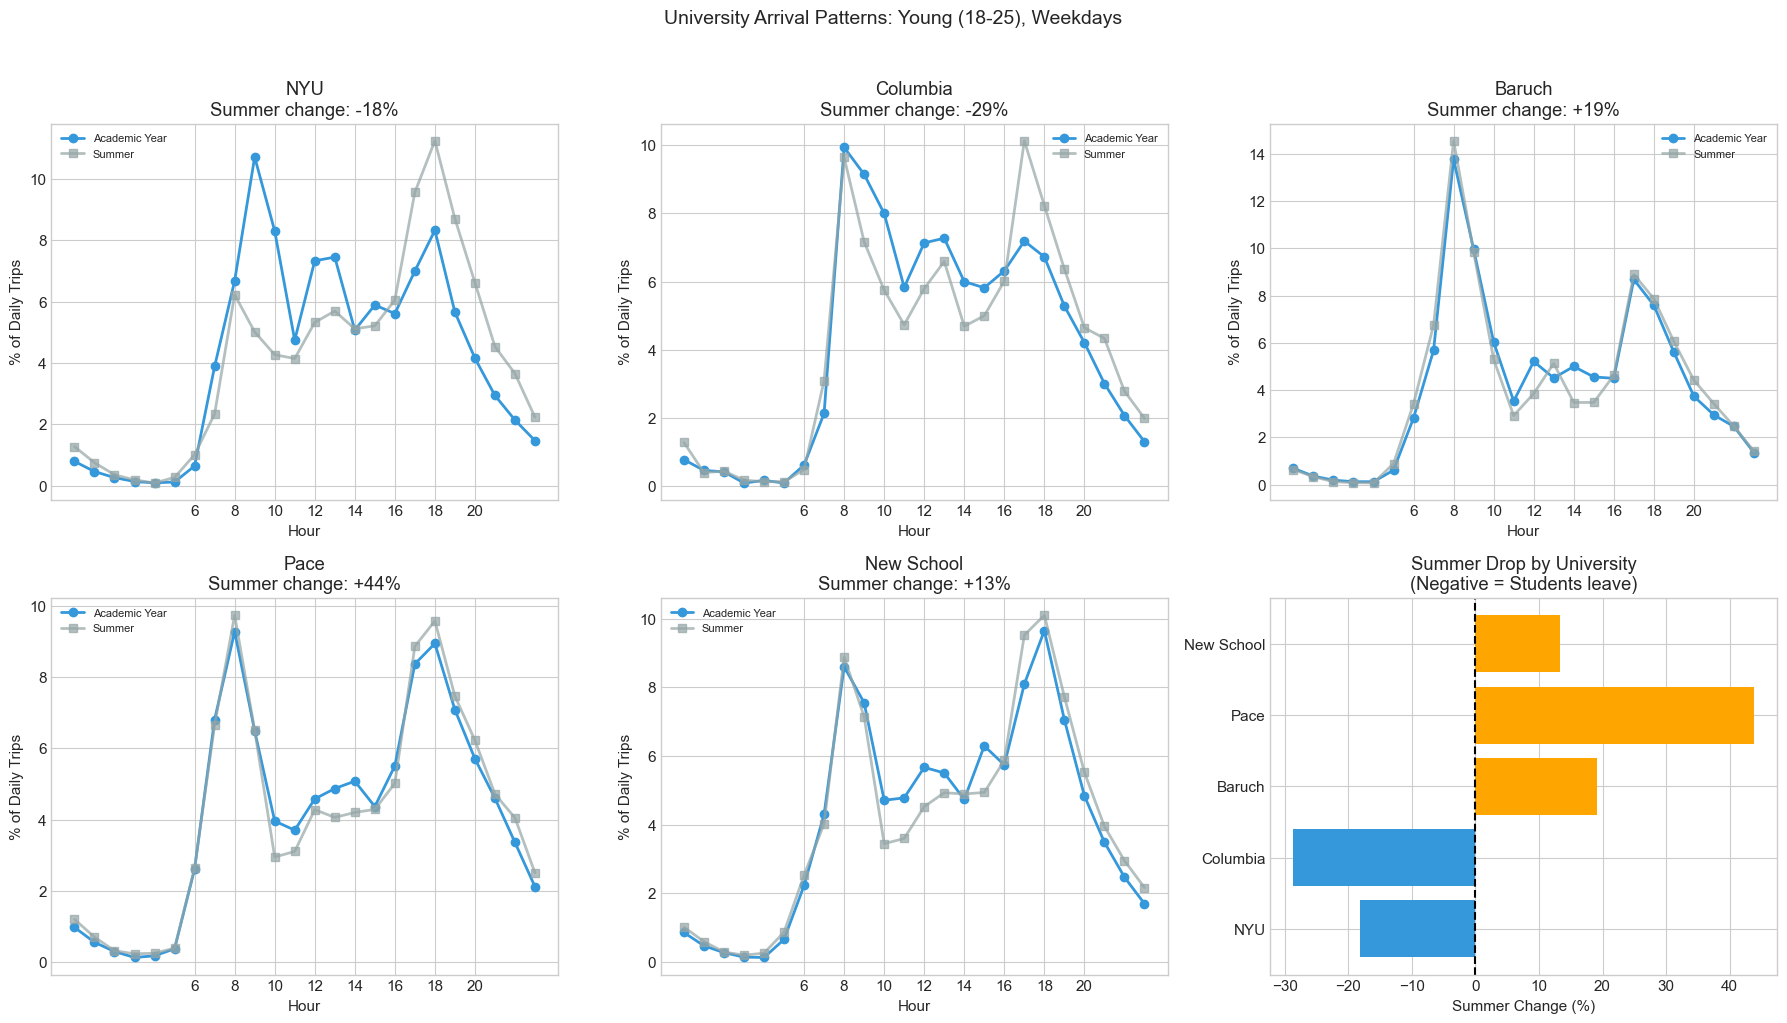

In [15]:
# Plot university comparisons
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

uni_summer_drops = {}

for idx, (uni_name, df) in enumerate(uni_comparison.items()):
    if idx >= 5:
        break
        
    ax = axes[idx]
    
    summer = df[df['season'] == 'summer'].sort_values('hour')
    academic = df[df['season'] == 'academic'].sort_values('hour')
    
    # Normalize
    summer_norm = summer['trips'] / summer['trips'].sum() * 100
    academic_norm = academic['trips'] / academic['trips'].sum() * 100
    
    ax.plot(academic['hour'], academic_norm, marker='o', label='Academic Year', color=STUDENT_COLOR, linewidth=2)
    ax.plot(summer['hour'], summer_norm, marker='s', label='Summer', color=CONTROL_COLOR, linewidth=2, alpha=0.7)
    
    # Calculate summer drop
    acad_total = df[df['season'] == 'academic']['trips'].sum()
    summer_total = df[df['season'] == 'summer']['trips'].sum()
    # Normalize by months (9 academic, 3 summer)
    summer_drop = (summer_total/3 - acad_total/9) / (acad_total/9) * 100
    uni_summer_drops[uni_name] = summer_drop
    
    ax.set_title(f'{uni_name}\nSummer change: {summer_drop:+.0f}%')
    ax.set_xlabel('Hour')
    ax.set_ylabel('% of Daily Trips')
    ax.legend(fontsize=8)
    ax.set_xticks(range(6, 22, 2))

# Summary
ax = axes[5]
unis = list(uni_summer_drops.keys())
drops = list(uni_summer_drops.values())
colors = [STUDENT_COLOR if d < 0 else 'orange' for d in drops]
ax.barh(unis, drops, color=colors)
ax.axvline(x=0, color='black', linestyle='--')
ax.set_xlabel('Summer Change (%)')
ax.set_title('Summer Drop by University\n(Negative = Students leave)')

plt.suptitle('University Arrival Patterns: Young (18-25), Weekdays', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 8. Summary: Identification Evidence

In [16]:
print("="*80)
print("DEEP DIVE FINDINGS: Intern vs Student Identification")
print("="*80)

print("\n--- INTERN EVIDENCE (Banks) ---")
print("\n1. ARRIVAL/DEPARTURE ASYMMETRY:")
print(f"   Summer asymmetry (arrivals/departures): {bank_summer_asym:.2f}")
print(f"   Academic year asymmetry: {bank_academic_asym:.2f}")
print(f"   Interpretation: {'Interns arrive but stay late (don\'t bike home)' if bank_summer_asym > bank_academic_asym else 'Unexpected'}")

print("\n2. BANK-SPECIFIC PATTERNS:")
for bank, asym in sorted(bank_asymmetries.items(), key=lambda x: -x[1]):
    print(f"   {bank}: {asym:.2f} asymmetry {'(brutal hours!)' if asym > 1.3 else ''}")

print("\n3. ARRIVAL WINDOW (8-11am TO Banks):")
print(f"   Summer boost in young/experienced ratio: {(summer_ratio - nonsummer_ratio) / nonsummer_ratio * 100:+.1f}%")

print("\n--- STUDENT EVIDENCE (Universities) ---")
print("\n1. SUMMER DROP:")
for uni, drop in sorted(uni_summer_drops.items(), key=lambda x: x[1]):
    print(f"   {uni}: {drop:+.1f}%")

print("\n2. ARRIVAL TIME SPREAD:")
print("   Students have more variable arrival times than bank workers")
print("   (Multiple class start times vs. single work start time)")

print("\n--- KEY IDENTIFICATION INSIGHTS ---")
print("\n1. Direction matters: Focus on trips TO destinations, not FROM")
print("2. Asymmetry reveals work culture: Interns arrive but don't leave on bikes")
print("3. Timing window (8-11am) isolates finance workers from early commuters")
print("4. Students have flatter arrival distributions (variable class times)")
print("5. Bank-specific patterns may reflect company culture")

print("\n" + "="*80)

SyntaxError: f-string expression part cannot include a backslash (1939594547.py, line 9)

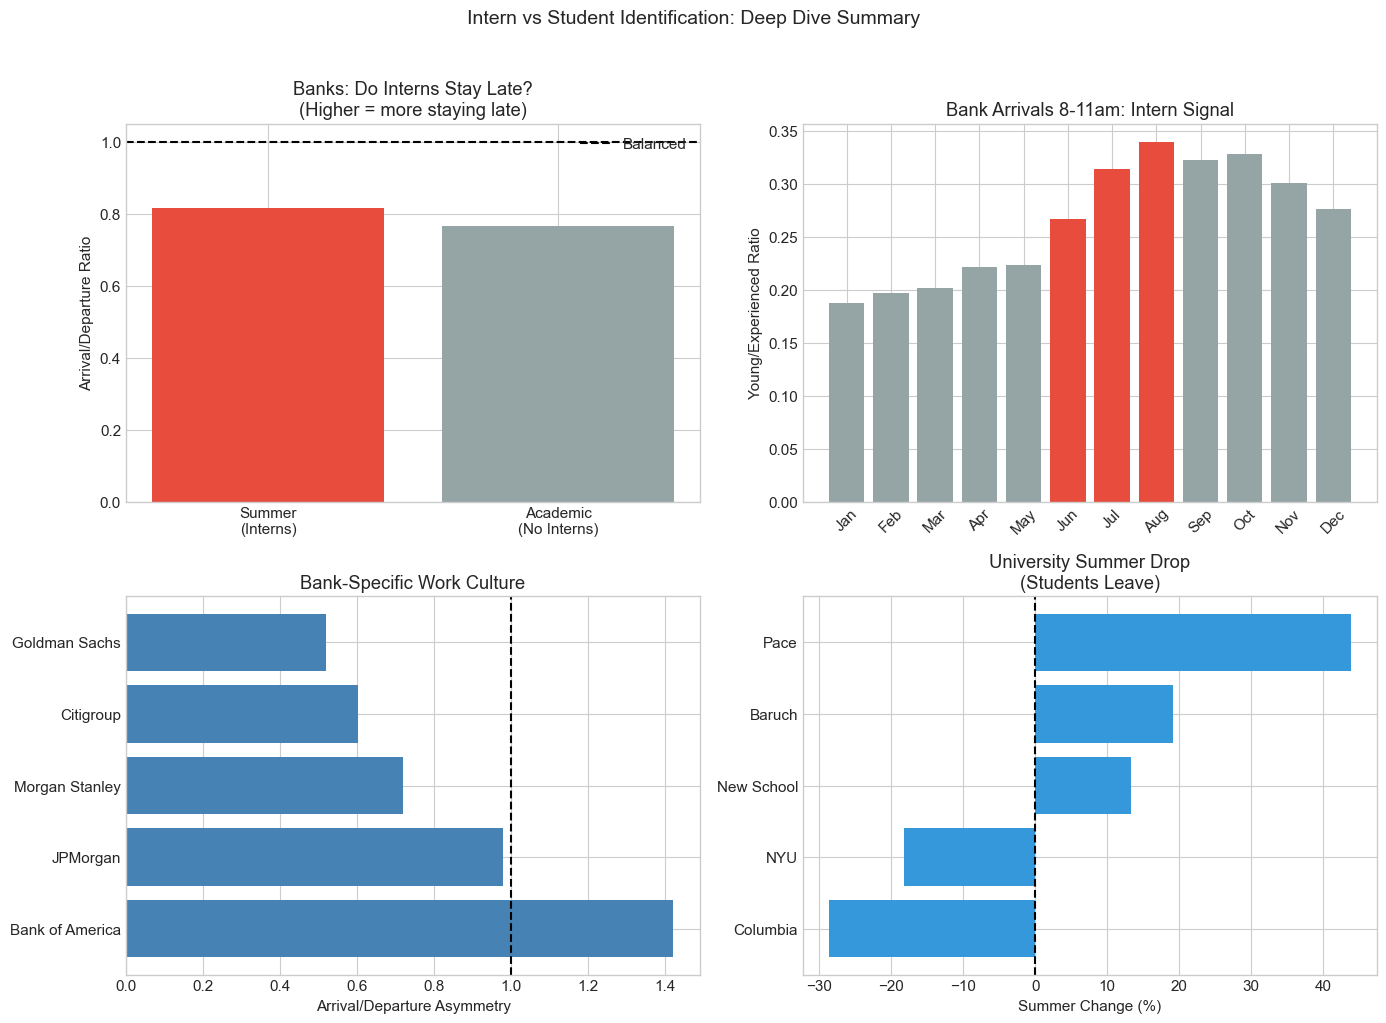

Saved to logs/intern_student_deep_dive.png


In [17]:
# Save summary figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Arrival/Departure asymmetry
ax = axes[0, 0]
ax.bar(['Summer\n(Interns)', 'Academic\n(No Interns)'], [bank_summer_asym, bank_academic_asym], 
       color=[INTERN_COLOR, CONTROL_COLOR])
ax.axhline(y=1.0, color='black', linestyle='--', label='Balanced')
ax.set_ylabel('Arrival/Departure Ratio')
ax.set_title('Banks: Do Interns Stay Late?\n(Higher = more staying late)')
ax.legend()

# 2. Monthly ratio
ax = axes[0, 1]
colors = [INTERN_COLOR if m in [6, 7, 8] else CONTROL_COLOR for m in range(1, 13)]
ax.bar(range(12), monthly_avg['ratio'], color=colors)
ax.set_xticks(range(12))
ax.set_xticklabels(month_labels, rotation=45)
ax.set_ylabel('Young/Experienced Ratio')
ax.set_title('Bank Arrivals 8-11am: Intern Signal')

# 3. Bank comparison
ax = axes[1, 0]
banks_sorted = sorted(bank_asymmetries.items(), key=lambda x: -x[1])
ax.barh([b[0] for b in banks_sorted], [b[1] for b in banks_sorted], color='steelblue')
ax.axvline(x=1.0, color='black', linestyle='--')
ax.set_xlabel('Arrival/Departure Asymmetry')
ax.set_title('Bank-Specific Work Culture')

# 4. University drops
ax = axes[1, 1]
unis_sorted = sorted(uni_summer_drops.items(), key=lambda x: x[1])
ax.barh([u[0] for u in unis_sorted], [u[1] for u in unis_sorted], color=STUDENT_COLOR)
ax.axvline(x=0, color='black', linestyle='--')
ax.set_xlabel('Summer Change (%)')
ax.set_title('University Summer Drop\n(Students Leave)')

plt.suptitle('Intern vs Student Identification: Deep Dive Summary', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../logs/intern_student_deep_dive.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved to logs/intern_student_deep_dive.png")